In [1]:
from foodbornenyc.models import models as m, documents as d, businesses as b, locations as l

In [2]:
db = m.getDBSession()

In [102]:
%%time
reviews = db.query(d.YelpReview).limit(100000).all()

CPU times: user 3.58 s, sys: 506 ms, total: 4.08 s
Wall time: 26.2 s


In [113]:
print len(reviews)
reviews = np.array(reviews)
sample = np.random.choice(reviews, size=10, replace=True) 

100000


In [114]:
print sample


[ <YelpReview: u"Why all the haters? I love San Loco! It may not be 100% authentic Mexican food, but it's damn good. All I really ever get is the Guaco Loco, which is delicious, but guacamole is pretty much my favorite thing ever (when it's made right, of course).\n\nTheir house sangria is pretty good too. I like that it comes in a glass jar!">
 <YelpReview: u'I really mean 3.5 stars.\n\nAgain, shout out to New York Magazine for featuring this place. This restaurant is incredible authetic and traditional to the point of "OMG, what am I eating?!" on some of the dishes/cold salads. We came here for lunch and they have a couple set menus for $20/person and believe you me, it\'s ENOUGH food. The bummer part was that a couple of the dishes mentioned in the set lunch weren\'t available that day so the chef substituted roe and some other items for this slimey squid salad that had the most "interesting" taste and texture I\'ve ever set my tongue on. \n\nI\'m not your terriyaki girl, I eat my e

In [5]:
import lda
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords

### Preprocess the reveiws 

In [15]:
#%%time
stop = stopwords.words('english')
#text = [r.text.strip('.').strip(',').strip('\n').split() for r in reviews]
#text = [ [word for word in doc if word not in stop and word not in ['.', ',']] for doc in text ]

In [16]:
print text[0]

[u'Big', u'place', u'always', u'find', u'seat.', u'Airy', u'light.', u'Hipster', u'crowd.', u'Good', u'stuff']


In [88]:
import csv
with open('reviews_foodborne.csv') as f:
    reader = csv.reader(f)
    reader.next()
    pos_data = [ row[0] for row in reader if float(row[1]) == 1.0]
with open('reviews_foodborne.csv') as f:
    reader = csv.reader(f)
    reader.next()
    neg_data = [ row[0] for row in reader if float(row[1]) == 0.0]

In [89]:
from sklearn.feature_extraction.text import CountVectorizer # an easier way

In [90]:
#%%time
sample = [r.text for r in reviews]
#alsample = sample + data
#labels = np.concatenate((np.zeros(len(sample)), np.ones(len(data)))).reshape((len(alsample), 1))
print len(neg_data)
doh_data = pos_data + neg_data
labels = np.concatenate((np.ones(len(pos_data)), np.zeros(len(neg_data)))).reshape((len(doh_data), 1))

2567


In [91]:
cv = CountVectorizer('content', strip_accents='unicode', analyzer='word', stop_words='english', max_df=.9, min_df=5, ngram_range=(1,1))
X = cv.fit_transform(doh_data)
# X = cv.fit_transform(data)

In [92]:
print X.shape
# print cv.vocabulary_
vocab = [x[0] for x in sorted(cv.vocabulary_.items(), key=lambda x:x[1])]
#print X

(5394, 5541)


In [ ]:
%%time
model = lda.LDA(n_topics=5, n_iter=1000, random_state=0)
model.fit(X)
print'\a'*10

In [101]:
print model.loglikelihood()


-2506311.67627
[10, 20, 30, 40]


In [136]:
sample = [ r.text for r in np.random.choice(reviews, size=len(pos_data), replace=False)]
print sample[:5]
data = pos_data + sample
labels = np.concatenate((np.ones(len(pos_data)), np.zeros(len(sample)))).reshape((len(data), 1))

[u"Great place for any event! I've been here a couple of times over the years and there dessert is amazing!! If you're a chocolate lover and you go to a place for the atmosphere then you'll LOVE this place! \n\nIts a must go to for all New Yorkers!! I've always been seated immediately which is a plus!\n\nThe only bad experience I had coming here was when I ordered the Peanut Butter Sundae. I usually ordered the Smores but I ordered this one by mistake and I am allergic to cinnamon. I don't know what was in it but I broke out in hives and my lips swelled up. I spoke to two waitresses and one server, and they all gave me different answers when I asked what was in it. Thankfully, I ran into the chef in the restroom and I complained about it to the manager, & it was taken off my bill.\n\nThe food isn't anything out of the ordinary but the desserts are definitely something else!", u'If you like sweets for cheap, this is the place to go. I recently visited this store on Christmas  eve. I pic

In [137]:
cv = CountVectorizer('content', strip_accents='unicode', analyzer='word', stop_words='english', max_df=.9, min_df=2, ngram_range=(1,1))
X = cv.fit_transform(data)
vocab = [x[0] for x in sorted(cv.vocabulary_.items(), key=lambda x:x[1])]
print "(N,V): ",X.shape

(N,V):  (5654, 9839)


In [140]:
%%time
models = []
for k in [2,3,4,5,10,20]:
    print "K: %r" % k
    model = lda.LDA(n_topics=k, n_iter=1000, random_state=0)
    model.fit(X)
    models.append({'k':k, 'score':model.loglikelihood(), 'model':model})

K: 2
K: 3
K: 4
K: 5
K: 10
K: 20
CPU times: user 3min 37s, sys: 605 ms, total: 3min 38s
Wall time: 3min 38s


In [141]:
for m in models:
    print 'score: ', m['score']
    model = m['model']
    topic_words = model.topic_word_
    k=10
    for i, topic_dist in enumerate(topic_words):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(k+1):-1]
        print('\tTopic {}: {}'.format(i, ', '.join(topic_words)))
        print
    print
    
# for just positives
# score:  -1094538.88719
# 	Topic 0: restaurant, like, service, came, didn, just, order, said, asked, minutes

# 	Topic 1: food, sick, got, place, poisoning, good, chicken, time, eating, ordered

score:  -2259098.97273
	Topic 0: good, place, great, food, like, just, really, service, time, little

	Topic 1: food, got, sick, place, poisoning, ordered, time, just, order, restaurant


score:  -2283525.63214
	Topic 0: place, good, great, food, like, service, just, really, bar, time

	Topic 1: food, got, sick, poisoning, place, time, ordered, restaurant, day, order

	Topic 2: good, food, chicken, like, ordered, just, sauce, really, place, rice


score:  -2295789.42964
	Topic 0: place, good, great, like, just, bar, time, really, ve, people

	Topic 1: food, good, chicken, like, rice, place, just, really, sushi, sauce

	Topic 2: food, got, sick, poisoning, place, time, ordered, order, day, bad

	Topic 3: good, food, great, service, really, came, ordered, place, cheese, burger


score:  -2302409.91674
	Topic 0: food, service, great, table, good, came, restaurant, dinner, night, ordered

	Topic 1: food, sick, got, poisoning, place, time, day, bad, eating, just

	Topic 2: place, good, grea

In [94]:

topic_words = model.topic_word_

for i, topic_dist in enumerate(topic_words):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(k+1):-1]
    print('Topic {}: {}'.format(i, ', '.join(topic_words)))
    print
    
#print alsample[12]

Topic 0: food, poisoning, got, sick, place, day, eat, eating, bad, ate, time, night, hours, stomach, ordered, went, chicken, restaurant, don, ve, just, know, days, worst, times, good, later, health, going, meal, really, terrible, away, think, horrible, diarrhea, home, didn, experience, vomiting, did, service, lunch, tasted, husband, sushi, avoid, gluten, review, ill

Topic 1: like, place, good, sick, just, ve, don, really, great, love, pizza, try, cream, nice, delicious, cheese, best, sweet, feel, little, want, time, ll, sandwich, come, new, coffee, tea, make, people, day, think, know, ice, eat, pretty, thing, chocolate, small, lot, fresh, cake, things, definitely, hot, free, say, better, prices, sure

Topic 2: order, said, just, time, asked, food, told, place, people, minutes, service, sick, did, like, didn, manager, know, called, don, restaurant, make, came, took, went, way, table, customer, come, guy, delivery, away, rude, want, left, wanted, experience, waiter, customers, staff, as

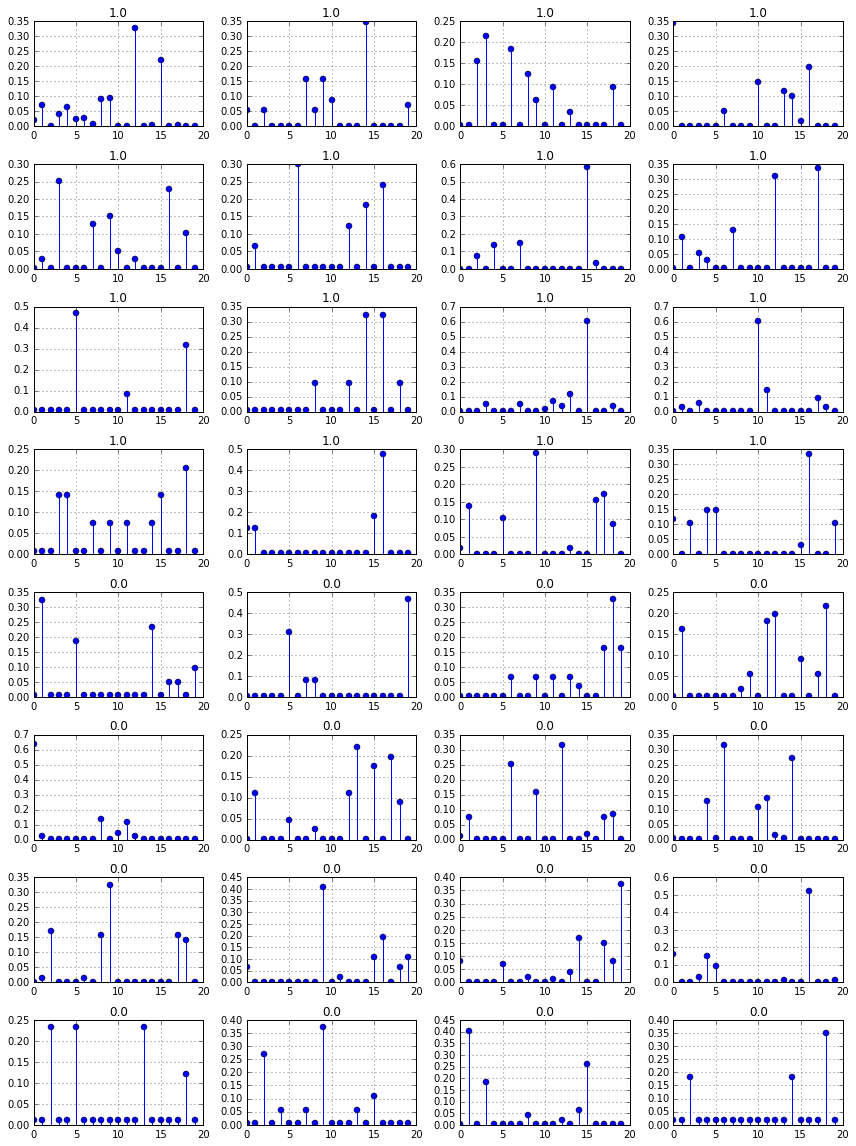

In [143]:
%matplotlib inline
import matplotlib.pyplot as plt
model = models[-1]['model']
thetas = model.doc_topic_
dists = np.hstack((thetas, labels))
#print results[0:10,:]
res_example = np.vstack((dists[0:16,:], dists[-16:,:]))
#print res_example.shape
fig, axarr = plt.subplots(8,4, figsize=(12,16))
for k,r in enumerate(res_example):
    #print i,j, ' :: ', r
    i,j = divmod(k,4)
    y = r[-1]
    x = r[:-1]
    axarr[i,j].stem(x)
    axarr[i,j].set_title(str(y))
    axarr[i,j].grid()
plt.tight_layout()
    